In [1]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [2]:
def classification(to_convert):
    final_list=[]
    for i in to_convert:
        if i>0.08:
            final_list.append(1)
        else:
            final_list.append(0)
    return final_list

### Separating features and target and feature scaling

In [3]:
df = pd.read_csv('pc1.csv')
df.head()
Y = df['defects']
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
X = df.loc[:, df.columns != 'defects']

X = X.apply(pd.to_numeric)
##print(X.head())
X_asDF = X

# Feature Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

Y = [(float(i)-min(Y))/(max(Y)-min(Y)) for i in Y]

### Extracting top 5 metrics and calculating Ru

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
feature_scores = {}
r_scores = []

from sklearn.linear_model import LinearRegression
import operator

reg = LinearRegression()

for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict(sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))


dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]
print(top_n_metrics)
#print(X_asDF.columns[top_n_metrics[0][0]])

list_keys = [x[0] for x in top_n_metrics]
print(X_asDF.columns[list_keys])
#print(list_keys)
X_train_for_multiple  = X_train[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

[(17, 0.08636128979108426), (0, 0.07982420695049741), (13, 0.07508993613775528), (12, 0.07431582575958484), (10, 0.06232867673161413)]
Index(['uniq_Opnd', 'loc', 'lOComment', 'lOCode', 'B'], dtype='object')
0.11918355063158148


### Applying proposed algorithm with Polynomial Regression

In [7]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(X)


poly.fit(X_poly,Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_poly, Y, test_size=0.2, random_state=1)
feature_scores = {}
r_scores = []

# Fitting Polynomial Regression to the dataset

from sklearn.linear_model import LinearRegression, Lasso
import operator

reg = LinearRegression() 
for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict( sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))


dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]
#print(top_n_metrics)
#print(X_asDF.columns[top_n_metrics[0][0]])

list_keys = [x[0] for x in top_n_metrics]
#print(list_keys)
X_train_for_multiple  = X_train[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

0.5531120727134429


### Proposed Algorithm with Ridge Regression

In [8]:
feature_scores = {}
r_scores = []

# Fitting Polynomial Regression to the dataset

from sklearn.linear_model import LinearRegression, Lasso, Ridge
import operator

reg = Ridge() 
for i in range(X_train.shape[1]):
    reg.fit(X_train[:,i].reshape(-1,1),Y_train)
    feature_scores[i] = reg.score(X_train[:,i].reshape(-1,1),Y_train)

sorted_feature_scores = dict(sorted(feature_scores.items(), key=operator.itemgetter(1),reverse=True))

dict_items = sorted_feature_scores.items()

top_n_metrics = list(dict_items)[:5]

list_keys = [x[0] for x in top_n_metrics]

X_train_for_multiple  = X_train[:,list_keys]
X_for_proposed = X[:,list_keys]
X_test_for_multiple  = X_test[:,list_keys]
reg.fit(X_train_for_multiple, Y_train)

rU = reg.score(X_train_for_multiple, Y_train)
print(rU)

IndexError: index 926 is out of bounds for axis 1 with size 42

### Calculating weights for the selected features

In [5]:
d = []
for i in list_keys:
    remaining_features = [j for j in list_keys if j != i ]
    X_train_remaining = X_train[:,remaining_features]
    X_test_remaining = X_test[:,remaining_features]
    reg.fit(X_train_remaining, Y_train)
    train_score = reg.score(X_train_remaining, Y_train)
    print(train_score)
    d.append(rU-train_score)

0.10669556597368535
0.1088079393361423
0.1076080809452239
0.10779855137498484
0.1173032920041337


### Normalising weights for and predicting the bug proneness index

In [6]:
norm_d = [(float(i)-min(d))/(max(d)-min(d)) for i in d]
print(norm_d)
#Weights should be mapped to elements in the list_keys
#norm_d are the normalized weights of the n metrics
Y_pred = []
for features_test in X_test:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_test[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
  

[1.0, 0.800864638057807, 0.9139763820333151, 0.8960205610388605, 0.0]


### Printing the predicted and the actual target

In [12]:
## The paper doesn't mention normalising again but some values don't lie in the range of 0 to 1
## Hence normalising again
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
Y_pred_final = [round(i,4) for i in Y_pred]
Y_test_final = [round(i,4) for i in Y_test]

"""
for(predicted, actual) in zip(Y_pred_final, Y_test_final):
    print(f"{predicted} - {actual}") 
    print()
"""

'\nfor(predicted, actual) in zip(Y_pred_final, Y_test_final):\n    print(f"{predicted} - {actual}") \n    print()\n'

## Function to classify bug count to 0 or 1

In [13]:
from imblearn.over_sampling import SMOTE
Y_train_classified = classification(Y_train)
Y_test_classified = classification(Y_test)
Y_pred_classified=classification(Y_pred_final)

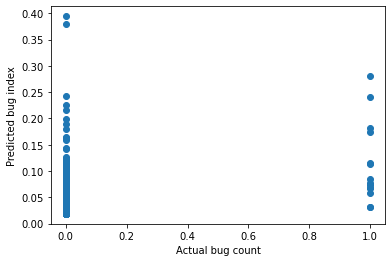

In [14]:
# Plotting of simple linear regression model

import matplotlib.pyplot as plt
X_train_for_singlefeat = X_train[:,list_keys[0]]
X_single_feat = X[:,list_keys[0]]
X_single_feat_2d = X_single_feat.reshape(-1,1)
X_test_for_singlefeat = X_test[:,list_keys[0]]
X_train_for_singlefeat_2d = X_train_for_singlefeat.reshape(-1,1)
reg.fit(X_train_for_singlefeat_2d,Y_train)
X_test_for_singlefeat_2d = X_test_for_singlefeat.reshape(-1,1)
Y_Predicted = reg.predict(X_test_for_singlefeat_2d)
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
plt.scatter(Y_test_final,Y_Predicted)

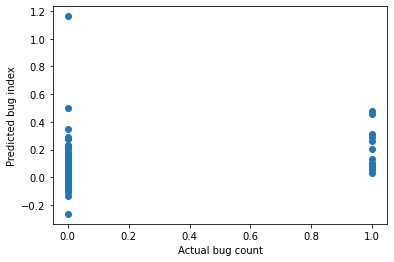

In [15]:
# Plotting of multiple linear regression

reg.fit(X_train,Y_train)
Y_Pred_multiplereg = reg.predict(X_test)
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
plt.scatter(Y_test,Y_Pred_multiplereg)


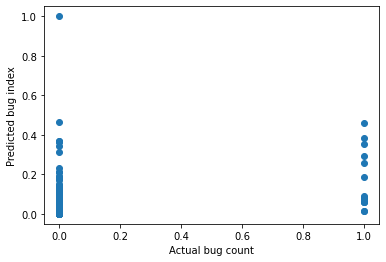

In [16]:
# Plotting of prosposed model
plt.xlabel("Actual bug count")
plt.ylabel("Predicted bug index")
plt.scatter(Y_test_final,Y_pred_final)


## Classificaton report for testing data
### Simple Linear regression

In [17]:
from sklearn.metrics import classification_report
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_test_for_singlefeat_2d)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.96      0.75      0.84       208
           1       0.12      0.50      0.19        14

    accuracy                           0.73       222
   macro avg       0.54      0.62      0.52       222
weighted avg       0.90      0.73      0.80       222



### Multiple Linear regression

In [18]:
reg.fit(X_train,Y_train)
Y_pred_multiple = reg.predict(X_test)
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred_multiple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.98      0.79      0.88       208
           1       0.19      0.71      0.30        14

    accuracy                           0.79       222
   macro avg       0.58      0.75      0.59       222
weighted avg       0.93      0.79      0.84       222



### Proposed model

In [19]:
Y_pred = []
for features_test in X_test:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_test[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y_test), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       208
           1       0.15      0.57      0.24        14

    accuracy                           0.77       222
   macro avg       0.56      0.68      0.56       222
weighted avg       0.91      0.77      0.83       222



In [20]:
# Accuracy - 3 
# Precision - 3
# Recall - 3
# F measure - 3

### Classification report for Training Data

### Simple Linear Regression

In [21]:
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_train_for_singlefeat_2d)
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       824
           1       0.17      0.63      0.27        63

    accuracy                           0.76       887
   macro avg       0.57      0.70      0.56       887
weighted avg       0.91      0.76      0.81       887



### Multiple Linear Regression

In [22]:
reg.fit(X_train,Y_train)
Y_pred_multiple = reg.predict(X_train)
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred_multiple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       824
           1       0.18      0.75      0.29        63

    accuracy                           0.74       887
   macro avg       0.58      0.74      0.56       887
weighted avg       0.92      0.74      0.80       887



### Proposed Model

In [23]:
Y_pred = []
for features_train in X_train:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features_train[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y_train), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       824
           1       0.16      0.33      0.22        63

    accuracy                           0.83       887
   macro avg       0.55      0.60      0.56       887
weighted avg       0.89      0.83      0.86       887



In [24]:
# Accuracy - 2
# Precision - 2
# Recall - 2
# F measure - 2

### Classification Report for overall data

### Simple Linear Regression

In [25]:
reg.fit(X_train_for_singlefeat_2d,Y_train)
Y_pred_simple = reg.predict(X_single_feat_2d)
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred_simple)))

Classification report : 
              precision    recall  f1-score   support

           0       0.96      0.77      0.85      1032
           1       0.16      0.61      0.26        77

    accuracy                           0.75      1109
   macro avg       0.56      0.69      0.55      1109
weighted avg       0.91      0.75      0.81      1109



### Multiple Linear Regression

In [26]:
reg.fit(X_train,Y_train)
Y_pred_overall = reg.predict(X)
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred_overall)))

Classification report : 
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      1032
           1       0.18      0.74      0.29        77

    accuracy                           0.75      1109
   macro avg       0.58      0.74      0.57      1109
weighted avg       0.92      0.75      0.81      1109



### Proposed Model

In [27]:
Y_pred = []
for features in X:
    tot = 0
    for (i, wt) in zip(list_keys, norm_d):
        tot = tot + features[i] * wt
    Y_pred.append(tot)
Y_pred = [(float(i)-min(Y_pred))/(max(Y_pred)-min(Y_pred)) for i in Y_pred]
print("Classification report : ")
print(classification_report(classification(Y), classification(Y_pred)))

Classification report : 
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1032
           1       0.17      0.35      0.23        77

    accuracy                           0.84      1109
   macro avg       0.56      0.61      0.57      1109
weighted avg       0.89      0.84      0.86      1109



### Applying classification models to the proposed model(5 selected features)

In [7]:
from imblearn.over_sampling import SMOTE

In [8]:
acc_scores = []
f1_scores = []
sm = SMOTE(random_state = 2)
from sklearn.naive_bayes import GaussianNB, ComplementNB
clf = GaussianNB()
Y_train_clf = classification(Y_train)
Y_test_clf = classification(Y_test)
X_train_res, y_train_res = sm.fit_resample(X_train_for_multiple, np.array(Y_train_clf).ravel())
X_test_res, y_test_res = sm.fit_resample(X_test_for_multiple, np.array(Y_test_clf).ravel())
clf.fit(X_train_res, y_train_res)
Y_pred = clf.predict(X_test_res)

from sklearn.metrics import f1_score,accuracy_score,classification_report
print("Classification report : ")
print(classification_report(y_test_res, classification(Y_pred)))

acc_scores.append(accuracy_score(y_test_res, classification(Y_pred)))
f1_scores.append(f1_score(y_test_res, classification(Y_pred), average='weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.60      0.92      0.72       208
           1       0.82      0.38      0.51       208

    accuracy                           0.65       416
   macro avg       0.71      0.65      0.62       416
weighted avg       0.71      0.65      0.62       416



In [9]:
acc_scores = []
f1_scores = []

from sklearn.naive_bayes import GaussianNB, ComplementNB
clf = GaussianNB()
Y_train_clf = classification(Y_train)
Y_test_clf = classification(Y_test)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)

from sklearn.metrics import f1_score,accuracy_score,classification_report
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))

acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       208
           1       0.28      0.36      0.31        14

    accuracy                           0.90       222
   macro avg       0.62      0.65      0.63       222
weighted avg       0.91      0.90      0.91       222



In [10]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = "entropy", splitter="random",min_samples_split=3)
Y_train_clf = classification(Y_train)
Y_test_clf = classification(Y_test)
X_train_res, y_train_res = sm.fit_resample(X_train_for_multiple, np.array(Y_train_clf).ravel())
X_test_res, y_test_res = sm.fit_resample(X_test_for_multiple, np.array(Y_test_clf).ravel())
clf.fit(X_train_res, y_train_res)
Y_pred = clf.predict(X_test_res)

from sklearn.metrics import f1_score,accuracy_score,classification_report
print("Classification report : ")
print(classification_report(y_test_res, classification(Y_pred)))

acc_scores.append(accuracy_score(y_test_res, classification(Y_pred)))
f1_scores.append(f1_score(y_test_res, classification(Y_pred), average='weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.60      0.95      0.74       208
           1       0.88      0.37      0.52       208

    accuracy                           0.66       416
   macro avg       0.74      0.66      0.63       416
weighted avg       0.74      0.66      0.63       416



In [11]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion = "entropy", splitter="random",min_samples_split=3)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))
acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       208
           1       0.33      0.36      0.34        14

    accuracy                           0.91       222
   macro avg       0.64      0.65      0.65       222
weighted avg       0.92      0.91      0.92       222



In [12]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='saga', penalty = 'l2', C = 0.1, random_state=10)
Y_train_clf = classification(Y_train)
Y_test_clf = classification(Y_test)
X_train_res, y_train_res = sm.fit_resample(X_train_for_multiple, np.array(Y_train_clf).ravel())
X_test_res, y_test_res = sm.fit_resample(X_test_for_multiple, np.array(Y_test_clf).ravel())
clf.fit(X_train_res, y_train_res)
Y_pred = clf.predict(X_test_res)

from sklearn.metrics import f1_score,accuracy_score,classification_report
print("Classification report : ")
print(classification_report(y_test_res, classification(Y_pred)))

acc_scores.append(accuracy_score(y_test_res, classification(Y_pred)))
f1_scores.append(f1_score(y_test_res, classification(Y_pred), average='weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.60      0.87      0.71       208
           1       0.76      0.43      0.55       208

    accuracy                           0.65       416
   macro avg       0.68      0.65      0.63       416
weighted avg       0.68      0.65      0.63       416



In [38]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='saga', penalty = 'l2', C = 0.1, random_state=10)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))
acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       208
           1       0.00      0.00      0.00        14

    accuracy                           0.94       222
   macro avg       0.47      0.50      0.48       222
weighted avg       0.88      0.94      0.91       222



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=35)
clf.fit(X_train_for_multiple, Y_train_clf)
Y_pred = clf.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))

acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       208
           1       0.00      0.00      0.00        14

    accuracy                           0.94       222
   macro avg       0.47      0.50      0.48       222
weighted avg       0.88      0.94      0.91       222



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
from sklearn.ensemble import RandomForestClassifier
rfs = RandomForestClassifier(n_estimators=300, criterion = "gini")
rfs.fit(X_train_for_multiple, Y_train_clf)
Y_pred = rfs.predict(X_test_for_multiple)
print("Classification report : ")
print(classification_report(Y_test_clf, classification(Y_pred)))
acc_scores.append(accuracy_score(Y_test_clf, classification(Y_pred)))
f1_scores.append(f1_score(Y_test_clf, classification(Y_pred), average = 'weighted'))

Classification report : 
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       208
           1       0.44      0.29      0.35        14

    accuracy                           0.93       222
   macro avg       0.70      0.63      0.66       222
weighted avg       0.92      0.93      0.93       222



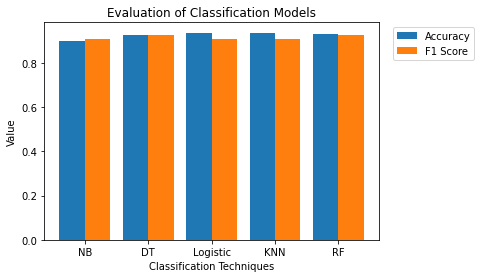

In [41]:
X = ["NB", "DT","Logistic", "KNN", "RF"]
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, acc_scores, 0.4, label = 'Accuracy')
plt.bar(X_axis + 0.2, f1_scores, 0.4, label = 'F1 Score')
plt.xticks(X_axis, X)
plt.xlabel("Classification Techniques")
plt.ylabel("Value")
plt.title("Evaluation of Classification Models")
plt.legend(bbox_to_anchor =(1.3, 1.0))
plt.show()

In [42]:
len(acc_scores)

5